In [1]:
import os
import json

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from pathlib import Path

os.environ['CUDA_VISIBLE_DEVICES'] = '2'
# solve the problem of "libdevice not found at ./libdevice.10.bc"
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/home/r10222035/.conda/envs/tf2'

2025-04-29 12:11:41.468438: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-29 12:11:41.551866: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
def get_testing_data(pairing_method):
    config_file = f'config_files/{pairing_method}_config_01.json'

    sig_path = f'./DNN_features/resonant-{pairing_method}.npy'
    bkg_path = f'./DNN_features/pp6b-{pairing_method}.npy'

    with open(config_file, 'r') as f:
        config = json.load(f)

    ns, nb = 50000, 50000
    X_s = np.load(sig_path)[:ns]
    X_b = np.load(bkg_path)[:nb]

    r_train, r_val, r_test = 0.7, 0.15, 0.15

    X_s_test = X_s[int(len(X_s)*(r_train+r_val)):]
    X_b_test = X_b[int(len(X_b)*(r_train+r_val)):]

    X_test = np.concatenate((X_s_test, X_b_test), axis=0)
    y_test = np.concatenate((np.ones(len(X_s_test)), np.zeros(len(X_b_test))), axis=0)

    return X_test, y_test

def get_sample_size(y):
    if len(y.shape) == 1:
        ns = (y == 1).sum()
        nb = (y == 0).sum()
    else:
        ns = (y.argmax(axis=1) == 1).sum()
        nb = (y.argmax(axis=1) == 0).sum()
    print(ns, nb)
    return ns, nb

# DM-CPV

In [3]:
# pairing_method = 'chi2_pairing'
# pairing_method = 'abs_pairing'
pairing_method = '4b_SPANet_pairing'
config_file = f'config_files/{pairing_method}_4b_1M_config_01.json'

In [4]:
# Read config file
with open(config_file, 'r') as f:
    config = json.load(f)

# sig_path = config['signal_npy_path']
# bkg_path = config['background_npy_path']
# ns = config['signal_size']
# nb = config['background_size']
batch_size = config['batch_size']

model_name = config['model_name']
sample_type = config['sample_type']

## Datasets

In [25]:
# X_test, y_test = get_testing_data(pairing_method)
X_test = np.load(f'./DNN_features/triHiggs-4pT40_6b-{pairing_method}-data.npy')
y_test = np.load(f'./DNN_features/triHiggs-4pT40_6b-{pairing_method}-label.npy')
test_size = get_sample_size(y_test)

50000 50000


In [26]:
BATCH_SIZE = batch_size
with tf.device('CPU'):
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
    test_dataset = test_dataset.batch(BATCH_SIZE)

## Event score distribution

In [27]:
save_model_name = f'DNN_models/last_model_{model_name}/'
loaded_model = tf.keras.models.load_model(save_model_name)

In [28]:
results = loaded_model.evaluate(test_dataset)
print(f'Testing Loss = {results[0]:.3}, Testing Accuracy = {results[1]:.3}')

49/49 [==============================] - 0s 4ms/step - loss: 0.3279 - accuracy: 0.8652
Testing Loss = 0.328, Testing Accuracy = 0.865


25/25 [==============================] - 0s 2ms/step


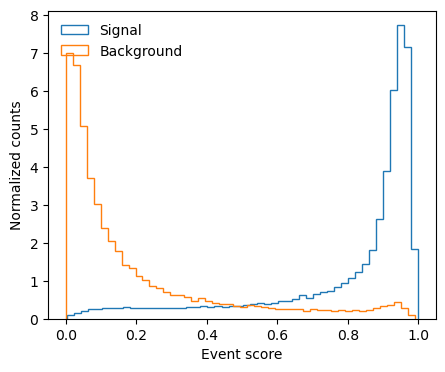

In [29]:
# plot DNN score distribution
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

y_pred_s = loaded_model.predict(X_test[y_test == 1], batch_size=BATCH_SIZE)
y_pred_b = loaded_model.predict(X_test[y_test == 0], batch_size=BATCH_SIZE)

ax.hist(y_pred_s, bins=50, histtype='step', label='Signal', density=True)
ax.hist(y_pred_b, bins=50, histtype='step', label='Background', density=True)

ax.set_xlabel('Event score')
ax.set_ylabel('Normalized counts')
ax.legend(frameon=False, loc='upper left')

# plt.savefig('../figures/DNN_event_score_resonant.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

In [30]:
np.save(f'../Upper_limit/DNN_selection/{pairing_method}/sig-1M.npy', y_pred_s)
np.save(f'../Upper_limit/DNN_selection/{pairing_method}/bkg-1M.npy', y_pred_b)

## Event score distribution

In [12]:
# Dense Neural Network
chi_s = np.load(f'../Upper_limit/DNN_selection/chi2_pairing/sig.npy')
chi_b = np.load(f'../Upper_limit/DNN_selection/chi2_pairing/bkg.npy')
abs_s = np.load(f'../Upper_limit/DNN_selection/abs_pairing/sig.npy')
abs_b = np.load(f'../Upper_limit/DNN_selection/abs_pairing/bkg.npy')
spanet_s = np.load(f'../Upper_limit/DNN_selection/4b_SPANet_pairing/sig.npy')
spanet_b = np.load(f'../Upper_limit/DNN_selection/4b_SPANet_pairing/bkg.npy')

# SPANet classifier
spanet_cls_s = np.load(f'../Upper_limit/SPANet_selection/sig.npy')
spanet_cls_b = np.load(f'../Upper_limit/SPANet_selection/bkg.npy')

In [13]:
n_bins = 50

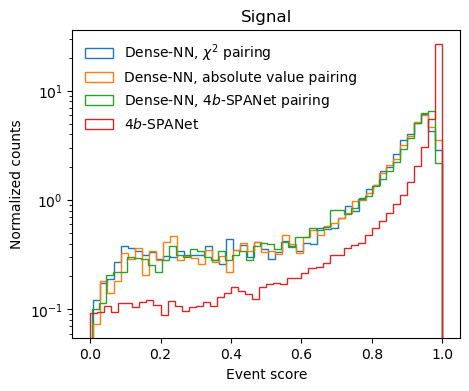

In [14]:
# plot event score distribution
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

ax.hist(chi_s, bins=n_bins, histtype='step', label='Dense-NN, $\chi^2$ pairing', density=True)
ax.hist(abs_s, bins=n_bins, histtype='step', label='Dense-NN, absolute value pairing', density=True)
ax.hist(spanet_s, bins=n_bins, histtype='step', label='Dense-NN, $4b$-SPANet pairing', density=True)
ax.hist(spanet_cls_s, bins=n_bins, histtype='step', label='$4b$-SPANet', density=True)

ax.set_title('Signal')
ax.set_xlabel('Event score')
ax.set_ylabel('Normalized counts')
ax.legend(frameon=False, loc='upper left')

ax.set_yscale('log')

plt.savefig('../figures/event_score_sig.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

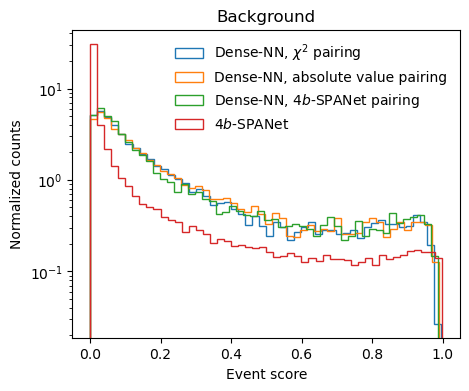

In [15]:
# plot event score distribution
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

ax.hist(chi_b, bins=n_bins, histtype='step', label='Dense-NN, $\chi^2$ pairing', density=True)
ax.hist(abs_b, bins=n_bins, histtype='step', label='Dense-NN, absolute value pairing', density=True)
ax.hist(spanet_b, bins=n_bins, histtype='step', label='Dense-NN, $4b$-SPANet pairing', density=True)
ax.hist(spanet_cls_b, bins=n_bins, histtype='step', label='$4b$-SPANet', density=True)

ax.set_title('Background')
ax.set_xlabel('Event score')
ax.set_ylabel('Normalized counts')
ax.legend(frameon=False)

ax.set_yscale('log')

plt.savefig('../figures/event_score_bkg.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

# TRSM

## 4 mass points mixed: 4b 750k sig + 1M bkg; 6b 12.5k sig + 50k bkg

In [6]:
m3_m2_list = [(420, 280), (500, 275), (500, 300), (520, 325)]
for pairing_method in ['chi2_pairing', 'abs_pairing', '4b_SPANet_pairing']:
    config_file = f'config_files/{pairing_method}-trsm_4b-mix_4-750k_config_01.json'

    # Read config file
    with open(config_file, 'r') as f:
        config = json.load(f)

    six_b_test_path = config['6b_test_npy_path']
    batch_size = config['batch_size']

    model_name = config['model_name']
    sample_type = config['sample_type']

    save_model_name = f'DNN_models/last_model_{model_name}/'
    loaded_model = tf.keras.models.load_model(save_model_name)
    
    # predict event score for each mass point and background
    for m3, m2 in m3_m2_list:
        six_b_test_path = f'./DNN_features/TRSM/TRSM_{m3}_{m2}/gghhh-4pT40_6b-1-{pairing_method}.npy'
        X_test = np.load(six_b_test_path.replace('.npy', '-data.npy'))
        y_test = np.load(six_b_test_path.replace('.npy', '-label.npy'))

        BATCH_SIZE = batch_size
        with tf.device('CPU'):
            test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
            test_dataset = test_dataset.batch(BATCH_SIZE)

        y_pred = loaded_model.predict(X_test, batch_size=BATCH_SIZE)

        output_dir = Path(f'../Upper_limit/DNN_selection/{pairing_method}/TRSM/TRSM_{m3}_{m2}')
        output_dir.mkdir(parents=True, exist_ok=True)

        np.save(output_dir / f'sig-mix_4-750k.npy', y_pred)

    six_b_test_path = f'./DNN_features/bkg/pp6b-4pT40_6b-1-{pairing_method}.npy'
    X_test = np.load(six_b_test_path.replace('.npy', '-data.npy'))
    y_test = np.load(six_b_test_path.replace('.npy', '-label.npy'))

    BATCH_SIZE = batch_size
    with tf.device('CPU'):
        test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
        test_dataset = test_dataset.batch(BATCH_SIZE)

    y_pred = loaded_model.predict(X_test, batch_size=BATCH_SIZE)

    output_dir = Path(f'../Upper_limit/DNN_selection/{pairing_method}/TRSM/pp6b')
    output_dir.mkdir(parents=True, exist_ok=True)

    np.save(output_dir / f'bkg-mix_4-750k.npy', y_pred)

25/25 [==============================] - 0s 1ms/step


## 5 mass points mixed: 4b 250k sig + 1M bkg; 6b 10k sig + 50k bkg

In [7]:
m3_m2_list = [(420, 280), (500, 275), (500, 300), (520, 325), (500, 350)]

for pairing_method in ['chi2_pairing', 'abs_pairing', '4b_SPANet_pairing']:
    config_file = f'config_files/{pairing_method}-trsm_4b-mix_5-250k_config_01.json'

    # Read config file
    with open(config_file, 'r') as f:
        config = json.load(f)
        six_b_test_path = config['6b_test_npy_path']
        batch_size = config['batch_size']
        model_name = config['model_name']
        sample_type = config['sample_type']

    save_model_name = f'DNN_models/last_model_{model_name}/'
    loaded_model = tf.keras.models.load_model(save_model_name)
    
    # predict event score for each mass point and background
    pair_method = 'mix_5-4b_SPANet_pairing' if pairing_method == '4b_SPANet_pairing' else pairing_method
    for m3, m2 in m3_m2_list:
        six_b_test_path = f'./DNN_features/TRSM/TRSM_{m3}_{m2}/gghhh-4pT40_6b-1-{pair_method}.npy'
        X_test = np.load(six_b_test_path.replace('.npy', '-data.npy'))
        y_test = np.load(six_b_test_path.replace('.npy', '-label.npy'))

        BATCH_SIZE = batch_size
        with tf.device('CPU'):
            test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
            test_dataset = test_dataset.batch(BATCH_SIZE)

        y_pred = loaded_model.predict(X_test, batch_size=BATCH_SIZE)

        output_dir = Path(f'../Upper_limit/DNN_selection/{pairing_method}/TRSM/TRSM_{m3}_{m2}')
        output_dir.mkdir(parents=True, exist_ok=True)

        np.save(output_dir / f'sig-mix_5-250k.npy', y_pred)

    six_b_test_path = f'./DNN_features/bkg/pp6b-4pT40_6b-1-{pair_method}.npy'
    X_test = np.load(six_b_test_path.replace('.npy', '-data.npy'))
    y_test = np.load(six_b_test_path.replace('.npy', '-label.npy'))

    BATCH_SIZE = batch_size
    with tf.device('CPU'):
        test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
        test_dataset = test_dataset.batch(BATCH_SIZE)

    y_pred = loaded_model.predict(X_test, batch_size=BATCH_SIZE)

    output_dir = Path(f'../Upper_limit/DNN_selection/{pairing_method}/TRSM/pp6b')
    output_dir.mkdir(parents=True, exist_ok=True)

    np.save(output_dir / f'bkg-mix_5-250k.npy', y_pred)

25/25 [==============================] - 0s 2ms/step


## 5 mass points mixed: 4b 1M sig + 1M bkg; 6b 10k sig + 50k bkg

In [3]:
m3_m2_list = [(420, 280), (500, 275), (500, 300), (520, 325), (500, 350)]

for pairing_method in ['chi2_pairing', 'abs_pairing', '4b_SPANet_pairing-mix_5-1M']:
    config_file = f'config_files/{pairing_method}-trsm_4b-mix_5-1M_config_01.json'

    # Read config file
    with open(config_file, 'r') as f:
        config = json.load(f)
        six_b_test_path = config['6b_test_npy_path']
        batch_size = config['batch_size']
        model_name = config['model_name']
        sample_type = config['sample_type']

    save_model_name = f'DNN_models/last_model_{model_name}/'
    loaded_model = tf.keras.models.load_model(save_model_name)
    
    # predict event score for each mass point and background
    for m3, m2 in m3_m2_list:
        six_b_test_path = f'./DNN_features/TRSM/TRSM_{m3}_{m2}/gghhh-4pT40_6b-test-{pairing_method}.npy'
        X_test = np.load(six_b_test_path.replace('.npy', '-data.npy'))
        y_test = np.load(six_b_test_path.replace('.npy', '-label.npy'))

        BATCH_SIZE = batch_size
        with tf.device('CPU'):
            test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
            test_dataset = test_dataset.batch(BATCH_SIZE)

        y_pred = loaded_model.predict(X_test, batch_size=BATCH_SIZE)

        output_dir = Path(f'../Upper_limit/DNN_selection/{pairing_method}/TRSM/TRSM_{m3}_{m2}')
        output_dir.mkdir(parents=True, exist_ok=True)

        np.save(output_dir / f'sig-mix_5-1M.npy', y_pred)

    six_b_test_path = f'./DNN_features/bkg/pp6b-4pT40_6b-test-{pairing_method}.npy'
    X_test = np.load(six_b_test_path.replace('.npy', '-data.npy'))
    y_test = np.load(six_b_test_path.replace('.npy', '-label.npy'))

    BATCH_SIZE = batch_size
    with tf.device('CPU'):
        test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
        test_dataset = test_dataset.batch(BATCH_SIZE)

    y_pred = loaded_model.predict(X_test, batch_size=BATCH_SIZE)

    output_dir = Path(f'../Upper_limit/DNN_selection/{pairing_method}/TRSM/pp6b')
    output_dir.mkdir(parents=True, exist_ok=True)

    np.save(output_dir / f'bkg-mix_5-1M.npy', y_pred)

2025-04-10 16:12:28.997518: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-10 16:12:29.655837: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22288 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:d8:00.0, compute capability: 8.6


5/5 [==============================] - 0s 2ms/step


2025-04-10 16:12:31.672320: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


25/25 [==============================] - 0s 1ms/step


## 5 mass points mixed: 4b 1M sig + 1M bkg; 6b 10k sig + 50k bkg, 24 nodes x 3

In [3]:
m3_m2_list = [(420, 280), (500, 275), (500, 300), (520, 325), (500, 350)]

for pairing_method in ['chi2_pairing', 'abs_pairing', '4b_SPANet_pairing-mix_5-1M']:
    config_file = f'config_files/{pairing_method}-trsm_4b-mix_5-1M-24_nodes-config_01.json'

    # Read config file
    with open(config_file, 'r') as f:
        config = json.load(f)
        six_b_test_path = config['6b_test_npy_path']
        batch_size = config['batch_size']
        model_name = config['model_name']
        sample_type = config['sample_type']

    save_model_name = f'DNN_models/last_model_{model_name}/'
    loaded_model = tf.keras.models.load_model(save_model_name)
    
    # predict event score for each mass point and background
    for m3, m2 in m3_m2_list:
        six_b_test_path = f'./DNN_features/TRSM/TRSM_{m3}_{m2}/gghhh-4pT40_6b-test-{pairing_method}.npy'
        X_test = np.load(six_b_test_path.replace('.npy', '-data.npy'))
        y_test = np.load(six_b_test_path.replace('.npy', '-label.npy'))

        BATCH_SIZE = batch_size
        with tf.device('CPU'):
            test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
            test_dataset = test_dataset.batch(BATCH_SIZE)

        y_pred = loaded_model.predict(X_test, batch_size=BATCH_SIZE)

        output_dir = Path(f'../Upper_limit/DNN_selection/{pairing_method}/TRSM/TRSM_{m3}_{m2}')
        output_dir.mkdir(parents=True, exist_ok=True)

        np.save(output_dir / f'sig-mix_5-1M-24_nodes.npy', y_pred)

    six_b_test_path = f'./DNN_features/bkg/pp6b-4pT40_6b-test-{pairing_method}.npy'
    X_test = np.load(six_b_test_path.replace('.npy', '-data.npy'))
    y_test = np.load(six_b_test_path.replace('.npy', '-label.npy'))

    BATCH_SIZE = batch_size
    with tf.device('CPU'):
        test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
        test_dataset = test_dataset.batch(BATCH_SIZE)

    y_pred = loaded_model.predict(X_test, batch_size=BATCH_SIZE)

    output_dir = Path(f'../Upper_limit/DNN_selection/{pairing_method}/TRSM/pp6b')
    output_dir.mkdir(parents=True, exist_ok=True)

    np.save(output_dir / f'bkg-mix_5-1M-24_nodes.npy', y_pred)

2025-04-29 09:07:00.859426: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-29 09:07:01.503766: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22288 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:d8:00.0, compute capability: 8.6


5/5 [==============================] - 0s 2ms/step


2025-04-29 09:07:03.421892: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


25/25 [==============================] - 0s 2ms/step


## 5 mass points mixed: 4b 150k sig + 150k bkg; 6b 10k sig + 50k bkg, 24 nodes x 3

In [3]:
m3_m2_list = [(420, 280), (500, 275), (500, 300), (520, 325), (500, 350)]

for pairing_method in ['chi2_pairing', 'abs_pairing', '4b_SPANet_pairing-mix_5-1M']:
    config_file = f'config_files/{pairing_method}-trsm_4b-mix_5-150k-24_nodes-config_01.json'

    # Read config file
    with open(config_file, 'r') as f:
        config = json.load(f)
        six_b_test_path = config['6b_test_npy_path']
        batch_size = config['batch_size']
        model_name = config['model_name']
        sample_type = config['sample_type']

    save_model_name = f'DNN_models/last_model_{model_name}/'
    loaded_model = tf.keras.models.load_model(save_model_name)
    
    # predict event score for each mass point and background
    for m3, m2 in m3_m2_list:
        six_b_test_path = f'./DNN_features/TRSM/TRSM_{m3}_{m2}/gghhh-4pT40_6b-test-{pairing_method}.npy'
        X_test = np.load(six_b_test_path.replace('.npy', '-data.npy'))
        y_test = np.load(six_b_test_path.replace('.npy', '-label.npy'))

        BATCH_SIZE = batch_size
        with tf.device('CPU'):
            test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
            test_dataset = test_dataset.batch(BATCH_SIZE)

        y_pred = loaded_model.predict(X_test, batch_size=BATCH_SIZE)

        output_dir = Path(f'../Upper_limit/DNN_selection/{pairing_method}/TRSM/TRSM_{m3}_{m2}')
        output_dir.mkdir(parents=True, exist_ok=True)

        np.save(output_dir / f'sig-mix_5-150k-24_nodes.npy', y_pred)

    six_b_test_path = f'./DNN_features/bkg/pp6b-4pT40_6b-test-{pairing_method}.npy'
    X_test = np.load(six_b_test_path.replace('.npy', '-data.npy'))
    y_test = np.load(six_b_test_path.replace('.npy', '-label.npy'))

    BATCH_SIZE = batch_size
    with tf.device('CPU'):
        test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
        test_dataset = test_dataset.batch(BATCH_SIZE)

    y_pred = loaded_model.predict(X_test, batch_size=BATCH_SIZE)

    output_dir = Path(f'../Upper_limit/DNN_selection/{pairing_method}/TRSM/pp6b')
    output_dir.mkdir(parents=True, exist_ok=True)

    np.save(output_dir / f'bkg-mix_5-150k-24_nodes.npy', y_pred)

2025-04-29 12:12:03.279820: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-29 12:12:03.944328: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22288 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:d8:00.0, compute capability: 8.6


5/5 [==============================] - 0s 2ms/step


2025-04-29 12:12:05.930983: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


25/25 [==============================] - 0s 1ms/step
